In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd

path = "Matches/"
json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]

colnames = ["matchId","summonerId","teamId","championId","baronKills","dragonKills","towerKills","userRank","matchDuration","kills","deaths","assists","winner"]
dfdict = collections.OrderedDict((colname, []) for colname in colnames)

counter = 0
for js in json_files:
    with open(os.path.join(path, js)) as json_file:
        data = json.load(json_file, "ISO-8859-1")

    for i in data["matches"]:
        for t in i["teams"]:
            dfdict['teamId'].extend([t["teamId"]]*5)
            dfdict['baronKills'].extend([t["baronKills"]]*5)
            dfdict['dragonKills'].extend([t["dragonKills"]]*5)
            dfdict['towerKills'].extend([t["towerKills"]]*5)
        for j in i["participantIdentities"]:
            dfdict['summonerId'].append(j['player']['summonerId'])
        for k in i["participants"]:
            dfdict['championId'].append(k['championId'])
            dfdict['matchId'].append(i['matchId'])
            dfdict["matchDuration"].append(i['matchDuration'])
            dfdict['userRank'].append(k["highestAchievedSeasonTier"])
            dfdict['kills'].append(k['stats']['kills'])
            dfdict['deaths'].append(k['stats']['deaths'])
            dfdict['assists'].append(k['stats']['assists'])
            dfdict['winner'].append(k['stats']['winner'])
            


matchdf = pd.DataFrame(dfdict)
matchdf

,matchId,summonerId,teamId,championId,baronKills,dragonKills,towerKills,userRank,matchDuration,kills,deaths,assists,winner
0,2054994244,51666047,100,236,1,1,5,UNRANKED,3067,6,13,16,False
1,2054994244,42726231,100,40,1,1,5,SILVER,3067,4,12,21,False
2,2054994244,49262934,100,75,1,1,5,SILVER,3067,16,7,11,False
3,2054994244,50204765,100,32,1,1,5,SILVER,3067,6,15,18,False
4,2054994244,53865827,100,98,1,1,5,SILVER,3067,13,17,14,False
5,2054994244,28903187,200,85,0,4,10,SILVER,3067,9,7,12,True
6,2054994244,63800895,200,157,0,4,10,SILVER,3067,5,14,13,True
7,2054994244,51403662,200,432,0,4,10,BRONZE,3067,5,4,25,True
8,2054994244,65760428,200,80,0,4,10,SILVER,3067,28,13,12,True
9,2054994244,19171337,200,67,0,4,10,UNRANKED,3067,17,8,15,True


In [3]:
# ranks = matchdf.groupby(["userRank"]).count()
matchdf["userRank"] = matchdf["userRank"].astype('category').cat.set_categories(
    ["UNRANKED", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND", "MASTER", "CHALLENGER"], ordered=True)

# Players EDA

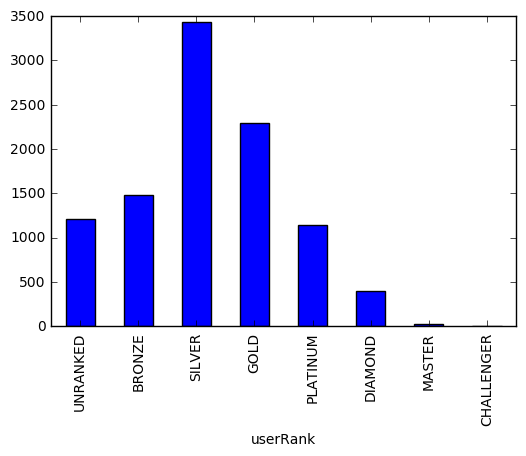

In [4]:
matchdf.groupby(['userRank'])['userRank'].count().plot(kind='bar')
plt.show()